# COGS 108 - Final Project 

# Overview

In March 2019, curfews were placed on a few select parks in San Diego in hopes to prevent night time crime. I conducted analysis on the reported crimes both before and after the curfews were imposed. I looked at differences in crime rates between neighborhoods in San Diego and differences between crime rates near the parks themselves. I found that there is likely much more to the story than just placing curfews on parks. Overall the curfews had no direct impact on crime rates both on the neighborhood scale, and the local park scale.

# Name & GitHub

- Name: Bobak Tabrizi
- GitHub Username: BobTabrizi

# Research Question

Would placing a curfew on parks lower crime rates in parks within cities of large population such as San Diego, California?

## Background and Prior Work

I came across this question last year upon attending a City Heights community meeting in early March of 2019. The question of park curfews was raised by local law enforcement and was passed around members of the community. Many saw rising crime rates as a concern, but nobody was certain on if a curfew would either help solve the problem or make it worse.

This is a question that has been brought up quite a few times by San Diegans in the past, and again this year. Law enforcement in San Diego believes in a positive outcome from a curfew. "Police say curfews can be effective at reducing crime because they limit opportunities for illegal activity and provide officers with another enforcement tool"[1].

Some residents in San Diego are on the flipside, in strong support of a curfew in areas that have historically seen more violence than others. "The park is known for open drug dealing, intravenous drug use and “chop shops” where stolen bikes are disassembled so they can be sold for parts. Needles have frequently been found near the park’s bathrooms and in grass where children play. 'It’s a really unsavory situation, and it’s been going on for years,'said Brian White, president of the Pacific Beach Town Council. 'We think a curfew can make a big difference.'"[3].

The amount of crimes that happen at parks in San Diego has been looked into a few times. The most recent of studies looked over several different parks and incidents that happened at late hours in the day. "Libby Lake Park is one of the most dangerous parks in the county, situated in the heart of Latino gang territory and, based on Yelp reviews, a place you especially want to avoid after dark. “I live in the area so I know about this park and the violence…,” wrote one Yelper[2]"

There were several curfews imposed in March 2019, for parks located in both City Heights and North Park[4].

References:

1)https://www.sandiegouniontribune.com/communities/san-diego/story/2020-02-16/park-curfews-on-the-rise-in-san-diego-in-response-to-crime-concerns

2)https://www.sandiegoreader.com/news/2020/jun/03/cover-san-diegos-deadliest-parks/

3)https://www.latimes.com/california/story/2019-12-24/san-diego-residents-lobby-for-curfew-at-what-some-call-felony-park

4)https://timesofsandiego.com/politics/2019/03/18/city-council-imposes-overnight-curfews-on-five-north-park-city-heights-parks/


# Hypothesis


Since curfews would deter gatherings of people in parks at night, I believe that implementing a park curfew would reduce crime rates in and around parks and make them and their surrounding areas safer for the overall public. I believe this increase in safety will be a result from giving the San Diego community an enforced window of time to avoid ending up in dangerous situations as I think that they are more likely to present themselves at night.

# Datasets

- Dataset Name: San Diego Crime Data 2019/2020/2018
- Link to the dataset: https://data.sandiego.gov/datasets/police-calls-for-service/
    - Number of observations: 590,967/522,569/570,459    
        - Total: 1,683,995
        
- Dataset Name: SANDAG Census
- Link to the dataset: https://datasurfer.sandag.org/
    - Number of observations: 7
            
I will be using three different datasets for my analysis from the San Diego Police Department. Each dataset represents one year of reported crimes to the San Diego Police Department from 2018-2020. Each contains the timestamp of the report, and location with street names and neighborhood codes.

I plan to combine these datasets to compare the difference in crime rates to observe the impact of park curfews placed on parks in San Diego.
        
        
          
I will also be using data from the SANDAG Census, primarily the populations of the neighborhoods in San Diego.
Since each neighborhood of San Diego has very different population sizes, we will examine the crime rate in proportion to population size for more accurate representation.



# Setup

In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

In [2]:
#Load Datasets
df_SD_18 = pd.read_csv("data/pd_calls_for_service_2018_datasd.csv")
df_SD_19 = pd.read_csv("data/pd_calls_for_service_2019_datasd.csv")
df_SD_20 = pd.read_csv("data/pd_calls_for_service_2020_datasd.csv")

# Data Cleaning

Out of the box, the data from the police department is fairly clean, however some data needs to be clarified for easier interpretation. I first dropped columns of variables that could cause issues with identification such as specific addresses and address numbers.Then I transformed the neighborhood codes listed by the police department into actual neighborhood names and combined subneighborhoods. After converting, I removed invalid logs which mainly consisted of PD records listing PD logs as street names and I also took a subset of the data with date and time ranges. I used this time range subset to get more accurate readings as in this analysis I will be observing the affects of curfews that take place at night time.

I initially planned on utilizing the days of the week and transformed them into values indicating the crime was committed on a weekend or weekday, however the results of the analysis did not seem to contribute much to proving/disproving my hypothesis so I have removed them as well.

## Step 1: Simplify + Clarify Column Data



First we seperate each year into its own dataframe. We drop addresses and incident numbers along with other unneeded variables as they don't add value to our investigation of crime occurence.

In [3]:
##Create dataframes seperated by years
df_18 = df_SD_18.drop(["incident_num","address_number_primary","address_dir_primary","address_dir_intersecting", "address_sfx_intersecting", "disposition","priority", "call_type","day_of_week"], axis = 1)
df_19 = df_SD_19.drop(["incident_num","address_number_primary","address_dir_primary","address_dir_intersecting", "address_sfx_intersecting", "disposition","priority", "call_type","day_of_week"], axis = 1)
df_20 = df_SD_20.drop(["incident_num","address_number_primary","address_dir_primary","address_dir_intersecting", "address_sfx_intersecting", "disposition","priority", "call_type", "day_of_week"], axis = 1)


##Create Dataframe with all data
df_all = df_SD_18 
df_all = df_all.append(df_SD_19)
df_all = df_all.append(df_SD_20)
df_all = df_all.drop(["incident_num","address_number_primary","address_dir_primary","address_dir_intersecting", "address_sfx_intersecting", "disposition","priority", "call_type"], axis = 1)

For each PD Code "Beat", there is a corresponding neighborhood in San Diego. This function will be used to turn the numbers which dont give immediate insight into a more informational metric that we will use to display crime occurences within each neighborhood. Additionally, some codes were subdivisions of a larger neighborhood. Consolidation of these codes into one master neighborhood is carried out as well. If the code is not one of the listed neighborhoods, we return -1 to indicate the data is not useful to us. 

To determine which neighborhoods to use, I utilized the following source: https://en.wikipedia.org/wiki/List_of_communities_and_neighborhoods_of_San_Diego

In [4]:
#### Beat 826 - 839,447 are City Heights Neighborhood codes
def standardize_neighborhood(nu):
    # Replace neighborhood codes with their actual names. First take care of neighborhoods with subdivisions
    if(nu == 826) or (nu == 827) or (nu == 828) or (nu == 829) or (nu == 830) or (nu == 831) or (nu == 832) or (nu == 833) or (nu == 834) or (nu == 835) or (nu == 836) or (nu == 837) or (nu == 838) or (nu == 839) or (nu == 447):
        nu =  'City Heights'
        return nu
    
    if(nu == 111) or (nu == 112) or (nu == 113) or (nu == 114) or (nu == 116):
        nu = 'Clairemont Mesa'
        return nu
        
    if(nu == 126) or (nu == 931) or (nu == 932) or (nu == 933):
        nu = 'Torrey Pines'
        return nu
    
    if(nu == 321) or (nu == 322) or (nu == 323) or (nu == 325):
        nu = 'Navajo'
        return nu
        
    if(nu == 431) or( nu == 432) or (nu == 433) or (nu == 435) or (nu == 439) or (nu == 445) or (nu == 446):
        nu = 'Encanto'
        return nu
        
    if(nu == 326) or (nu == 327):
        nu = 'College Area'
        return nu
        
    if(nu == 521) or (nu == 522) or (nu == 523) or (nu == 524) or (nu == 526) or (nu == 527) or (nu == 528):
        nu = 'Downtown'
        return nu
        
    if(nu == 612) or (nu == 613) or (nu == 615) or (nu == 616) or (nu == 617) or (nu == 618):
        nu = 'Point Loma'
        return nu
        
        
    #Next the sole neighborhoods
  
    if(nu == 115):
        nu = 'University City'   
        return nu
    if(nu == 121):
        nu = 'Mission Beach'       
        return nu
    if(nu == 122):
        nu = 'Pacific Beach'       
        return nu
    if(nu == 123):
        nu = 'Mission Bay Park'       
        return nu
    if(nu == 124):
        nu = 'La Jolla'     
        return nu
    if(nu == 231):
        nu = 'Sabre Springs' 
        return nu
    if(nu == 232):
        nu = 'Carmel Mountain'  
        return nu
    if(nu == 233):
        nu = 'Rancho Penasquitos'
        return nu
    if(nu == 234):
        nu = 'Rancho Bernardo'
        return nu
    if(nu == 235):
        nu = 'San Pasqual'
        return nu
    if(nu == 241):
        nu = 'Scripps Ranch'
        return nu
    if(nu == 242):
        nu = 'Mira Mesa'  
        return nu
    if(nu == 243):
        nu = 'Miramar'   
        return nu
    if(nu == 245):
        nu = 'Rancho Encantada'
        return nu
    if(nu == 246):
        nu = 'Miramar Ranch North'
        return nu
    if(nu == 311):
        nu = 'Serra Mesa'
        return nu
    if(nu == 312):
        nu = 'Tierrasanta'
        return nu
    if(nu == 313):
        nu = 'Kearny Mesa'
        return nu
    if(nu == 314):
        nu = 'Birdland'
        return nu
    if(nu == 315):
        nu = 'Mission Valley East'
        return nu
    if(nu == 316):
        nu = 'Qualcomm'
        return nu
    if(nu == 324):
        nu = 'Lake Murray'
        return nu
    if(nu == 434):
        nu = 'Jamacha/Lomita'
        return nu
    if(nu == 436):
        nu = 'Skyline'
        return nu
    if(nu == 437):
        nu = 'Bay Terraces'
        return nu
    if(nu == 438):
        nu = 'Paradise Hills'
        return nu
    if(nu == 441):
        nu = 'Mountain View'
        return nu
    if(nu == 442):
        nu = 'Southcrest'
        return nu
    if(nu == 443):
        nu = 'Shelltown'
        return nu
    if(nu == 444):
        nu = 'Mt. Hope'
        return nu
    if(nu == 451):
        nu = 'Oak Park'
        return nu
    if(nu == 452):
        nu = 'O Farrel'
        return nu
    if(nu == 511):
        nu = 'Barrio Logan'
        return nu
    if(nu == 512):
        nu = 'Logan Heights'
        return nu
    if(nu == 514):
        nu = 'Sherman Heights'
        return nu
    if(nu == 515):
        nu = 'Grant Hill'
        return nu
    if(nu == 516):
        nu = 'Stockton'
        return nu
    if(nu == 517):
        nu = 'Golden Hill'
        return nu
    if(nu == 518):
        nu = 'South Park'
        return nu
    if(nu == 525):
        nu = 'Horton Plaza'
        return nu
    if(nu == 529):
        nu = 'Park West'
        return nu
    if(nu == 531):
        nu = 'Balboa Park'
        return nu
    if(nu == 541):
        nu = 'Petco Park'
        return nu
    if(nu == 611):
        nu = 'Midway District'
        return nu
    if(nu == 614):
        nu = 'Ocean Beach'
        return nu
    if(nu == 621):
        nu = 'Linda Vista'
        return nu
    if(nu == 622):
        nu = 'Morena'
        return nu
    if(nu == 623):
        nu = 'Mission Valley West'
        return nu
    if(nu == 624):
        nu = 'University Heights'
        return nu
    if(nu == 625):
        nu = 'Old Town'
        return nu
    if(nu == 626):
        nu = 'Mission Hills'
        return nu
    if(nu == 627):
        nu = 'Hillcrest'
        return nu
    if(nu == 628):
        nu = 'Midtown'
        return nu
    if(nu == 711):
        nu = 'Tijuana River Valley'
        return nu
    if(nu == 712):
        nu = 'San Ysidro'
        return nu
    if(nu == 713):
        nu = 'Otay Mesa'
        return nu
    if(nu == 714):
        nu = 'Border'
        return nu
    if(nu == 721):
        nu = 'Egger Highlands'
        return nu
    if(nu == 722):
        nu = 'Nestor'
        return nu
    if(nu == 723):
        nu = 'Otay Mesa West'
        return nu
    if(nu == 724):
        nu = 'Palm City'
        return nu
    if(nu == 725):
        nu = 'Ocean Crest'
        return nu
    if(nu == 811):
        nu = 'Normal Heights'
        return nu
    if(nu == 812):
        nu = 'Burlingame'
        return nu
    if(nu == 813):
        nu = 'North Park'
        return nu
    if(nu == 814):
        nu = 'Adams North'
        return nu
    if(nu == 821):
        nu = 'Rolando'
        return nu
    if(nu == 822):
        nu = 'El Cerrito'
        return nu
    if(nu == 823):
        nu = 'Redwood Village'
        return nu
    if(nu == 824):
        nu = 'Talmadge'
        return nu
    if(nu == 825):
        nu = 'Kensington'
        return nu
    if(nu == 841):
        nu = 'Rolando Park'
        return nu
    if(nu == 934):
        nu = 'Carmel Valley'
        return nu
    if(nu == 935):
        nu = 'North City'
        return nu
    if(nu == 936):
        nu = 'Torrey Highlands'
        return nu
    if(nu == 937):
        nu = 'Black Mountain Ranch'
        return nu
    

    return -1

Applying our function to convert into neighborhood names. Additionally, rename the column frames for clarity so the table is easier to read.

In [5]:
#Apply our standardize function. Convert all codes into neighborhood names. 
df_18['beat'] = df_18['beat'].apply(standardize_neighborhood)
df_19['beat'] = df_19['beat'].apply(standardize_neighborhood)
df_20['beat'] = df_20['beat'].apply(standardize_neighborhood)
df_all['beat'] = df_all['beat'].apply(standardize_neighborhood)
df_18 = df_18.rename(columns = {'date_time': 'Time/Day', 'address_road_primary':'Street Name', 'address_sfx_primary': 'Suffix', 'address_road_intersecting': 'Intersection','beat': 'Neighborhood'})
df_19 = df_19.rename(columns = {'date_time': 'Time/Day', 'address_road_primary':'Street Name', 'address_sfx_primary': 'Suffix', 'address_road_intersecting': 'Intersection','beat': 'Neighborhood'})
df_20 = df_20.rename(columns = {'date_time': 'Time/Day', 'address_road_primary':'Street Name', 'address_sfx_primary': 'Suffix', 'address_road_intersecting': 'Intersection','beat': 'Neighborhood'})
df_all = df_all.rename(columns = {'date_time': 'Time/Day', 'address_road_primary':'Street Name', 'address_sfx_primary': 'Suffix', 'address_road_intersecting': 'Intersection','beat': 'Neighborhood'})

## Step 2: Remove Invalid Logs & Filter/Group Crimes by Time

We are primarily interested in keeping record of yearly intervals starting 
after March 31th. Since the curfew took effect 3/20/19.
Additionally, since we don't have the full data for December 2020, we will cut off our data from before December 1st. 
If we take a look at the data set, We notice that there are some neighborhoods with -1 values with strange streets such as PD Logs as the street names.

We will remove all of these rows since they do not belong to a specific neighborhood or valid neighborhood of interest.

Also, since the earliest curfew takes place from 9 PM and the latest curfew to 6 AM. We will filter out all data that is outside of the curfew range so we can examine the effects of the curfew on rate of crime.



In [6]:
df_18 = df_18[df_18["Neighborhood"] != -1]
df_18 = df_18[(df_18["Time/Day"] > "2018-04-01 00:00:00") & (df_18["Time/Day"] < "2018-12-01 00:00:00")]
df_18 = df_18[df_18["Time/Day"].str.contains(" 21:") | df_18["Time/Day"].str.contains(" 22:") | df_18["Time/Day"].str.contains(" 23:") | df_18["Time/Day"].str.contains(" 00:") | df_18["Time/Day"].str.contains(" 01:") | df_18["Time/Day"].str.contains(" 02:") | df_18["Time/Day"].str.contains(" 03:") |  df_18["Time/Day"].str.contains(" 04:") |  df_18["Time/Day"].str.contains(" 05:") | df_18["Time/Day"].str.contains(" 06:")]
df_19 = df_19[df_19["Neighborhood"] != -1]
df_19 = df_19[(df_19["Time/Day"] > "2019-04-01 00:00:00") & (df_19["Time/Day"] < "2019-12-01 00:00:00")]
df_19 = df_19[df_19["Time/Day"].str.contains(" 21:") | df_19["Time/Day"].str.contains(" 22:") | df_19["Time/Day"].str.contains(" 23:") | df_19["Time/Day"].str.contains(" 00:") | df_19["Time/Day"].str.contains(" 01:") | df_19["Time/Day"].str.contains(" 02:") | df_19["Time/Day"].str.contains(" 03:") |  df_19["Time/Day"].str.contains(" 04:") |  df_19["Time/Day"].str.contains(" 05:") | df_19["Time/Day"].str.contains(" 06:")]
df_20= df_20[df_20["Neighborhood"] != -1]
df_20= df_20[(df_20["Time/Day"] > "2020-04-01 00:00:00") & (df_20["Time/Day"] < "2020-12-01 00:00:00")]
df_20= df_20[df_20["Time/Day"].str.contains(" 21:") | df_20["Time/Day"].str.contains(" 22:") | df_20["Time/Day"].str.contains(" 23:") | df_20["Time/Day"].str.contains(" 00:") | df_20["Time/Day"].str.contains(" 01:") | df_20["Time/Day"].str.contains(" 02:") | df_20["Time/Day"].str.contains(" 03:") |  df_20["Time/Day"].str.contains(" 04:") |  df_20["Time/Day"].str.contains(" 05:") | df_20["Time/Day"].str.contains(" 06:")]

Since I am interested in rate of crime, I will observe the rate of crimes occured by month. The following function takes in the timestamp and returns a month string. We then apply the function and can now group crimes by month and neighborhood.

In [7]:
def standardize_month(string):
    Month = string[5:7]
    return Month

In [8]:
df_18['Month'] = df_18['Time/Day'].apply(standardize_month)
df_19['Month'] = df_19['Time/Day'].apply(standardize_month)
df_20['Month'] = df_20['Time/Day'].apply(standardize_month)

# Data Wrangling

With the clean data, I still needed to modify and group specific subsets of data together to perform my analysis. Since there are so many neighborhoods, I cut down the number of neighborhoods to focus on so we can more easily observe the data visually. Since each neighborhood has a different population, I took the proportion of crime by population to observe crime rate. I then took all streets surrounding the parks with curfews and labeled them as a park street to conduct further analysis on the crimes near parks directly.

## Step 1: Filter by Neighborhood

To get a comparison on the curfew's effects. We will split the data by Neighborhood.

Since there are so many neighborhoods in San Diego, we will take the top 7 neighborhoods with the largest volume of crime rates. 

In [9]:
df_18['Neighborhood'].value_counts().head(7)

Downtown           13425
City Heights        8281
Pacific Beach       7732
Clairemont Mesa     4816
North Park          3670
Hillcrest           3137
Encanto             2985
Name: Neighborhood, dtype: int64

In [10]:
df_19['Neighborhood'].value_counts().head(7)

Downtown           13868
City Heights        8036
Pacific Beach       7242
Clairemont Mesa     4592
Encanto             3428
North Park          3391
Hillcrest           3254
Name: Neighborhood, dtype: int64

In [11]:
df_20['Neighborhood'].value_counts().head(7)

Downtown           14402
City Heights        8027
Pacific Beach       5377
Clairemont Mesa     3782
Encanto             3453
North Park          3008
Midway District     2911
Name: Neighborhood, dtype: int64

We find that the top 7 neighborhoods are: Downtown, City Heights, Pacific Beach, Clairemont Mesa, North Park, Hillcrest, and Encanto. 

Unsurprisingly, City Heights and North Park are in this list. 

We then seperate each neighborhood into individual dataframes.

In [12]:
df_DT = df_18[df_18['Neighborhood'] == 'Downtown']
df_DT_18 = df_DT
t1 = df_19.loc[df_19['Neighborhood'] == 'Downtown']
df_DT_19 = t1
df_DT = df_DT.append(t1)
t2 = df_20.loc[df_20['Neighborhood'] == 'Downtown']
df_DT_20 = t2
df_DT = df_DT.append(t2)

df_CH = df_18[df_18['Neighborhood'] == 'City Heights']
df_CH_18 = df_CH
t1 = df_19.loc[df_19['Neighborhood'] == 'City Heights']
df_CH_19 = t1
df_CH = df_CH.append(t1)
t2 = df_20.loc[df_20['Neighborhood'] == 'City Heights']
df_CH_20 = t2
df_CH = df_CH.append(t2)

df_NP = df_18[df_18['Neighborhood'] == 'North Park']
df_NP_18 = df_NP
t1 = df_19.loc[df_19['Neighborhood'] == 'North Park']
df_NP_19 = t1
df_NP = df_NP.append(t1)
t2 = df_20.loc[df_20['Neighborhood'] == 'North Park']
df_NP_20 = t2
df_NP = df_NP.append(t2)

df_PB = df_18[df_18['Neighborhood'] == 'Pacific Beach']
df_PB_18 =df_PB
t1 = df_19.loc[df_19['Neighborhood'] == 'Pacific Beach']
df_PB = df_PB.append(t1)
df_PB_19 = t1
t2 = df_20.loc[df_20['Neighborhood'] == 'Pacific Beach']
df_PB_20 = t2
df_PB = df_PB.append(t2)

df_CM = df_18[df_18['Neighborhood'] == 'Clairemont Mesa']
df_CM_18 = df_CM
t1 = df_19.loc[df_19['Neighborhood'] == 'Clairemont Mesa']
df_CM_19 = t1
df_CM = df_CM.append(t1)
t2 = df_20.loc[df_20['Neighborhood'] == 'Clairemont Mesa']
df_CM_20 = t2
df_CM = df_CM.append(t2)

df_HC = df_18[df_18['Neighborhood'] == 'Hillcrest']
df_HC_18 = df_HC 
t1 = df_19.loc[df_19['Neighborhood'] == 'Hillcrest']
df_HC_19 = t1
df_HC = df_HC.append(t1)
t2 = df_20.loc[df_20['Neighborhood'] == 'Hillcrest']
df_HC_20 = t2
df_HC = df_HC.append(t2)

df_EN = df_18[df_18['Neighborhood'] == 'Encanto']
df_EN_18 = df_EN
t1 = df_19.loc[df_19['Neighborhood'] == 'Encanto']
df_EN_19 = t1
df_EN = df_EN.append(t1)
t2 = df_20.loc[df_20['Neighborhood'] == 'Encanto']
df_EN_20 = t2
df_EN = df_EN.append(t2)

## Step 2: Identify Streets Near Parks

We will create an identifier for streets near parks to analyze more closely the potential difference in crime rates after and before the curfew was put into effect. The following parks were given a curfew.


Cedar Ridge Mini Park   	- Pentuckett Ave

Montclair Neighborhood Park	- Nile Street,  Quince Street, Haller Street

North Park Community Park 	- Howard Avenue, Oregon Street, Idaho Street, Polk Ave, Lincoln Ave

North Park Mini Park. 		- Granada Ave, North Park Way, 29th Street

City Heights Mini Park - 43rd street, Polk Ave, Fairmount Ave, University Ave


We First Create a set of lists of crimes committed by parks for each month, and then we add an identifier that the crime was a nearby park crime to our yearly dataframes.

In [13]:
###First Search for City Heights Mini park streets, make sure the crimes found are within City Heights / North Park Region
df_park_18 = df_18[((df_18['Street Name'] == "POLK") | (df_18['Street Name'] == '43RD') | (df_18['Street Name'] == "FAIRMOUNT") | (df_18['Street Name'] == "UNIVERSITY")) & ((df_18['Neighborhood'] == "City Heights") | (df_18['Neighborhood'] == "North Park"))]
###Then Search for other neighborhoods. 
a1 = df_18[(df_18['Street Name'] == 'PENTUCKETT') | ((df_18['Street Name'] == 'NILE'))]
df_park_18 = df_park_18.append(a1)
a2 = df_18[(((df_18['Street Name'] == 'QUINCE') & (df_18['Suffix'] == 'ST'))) & ((df_18['Intersection'] == 'NILE') | (df_18['Intersection'] == 'VANCOUVER') | (df_18['Intersection'] == 'HALLER'))]
df_park_18 = df_park_18.append(a2)
df_park_18 = df_park_18.append(df_18[df_18['Street Name'] == "HALLER"])
df_park_18 = df_park_18.append(df_18[(df_18['Street Name'] == 'HOWARD') & (df_18['Neighborhood'] == 'North Park')])
df_park_18 = df_park_18.append(df_18[(df_18['Street Name'] == 'IDAHO') | (df_18['Street Name'] == 'OREGON')] )
df_park_18 = df_park_18.append(df_18[(df_18['Street Name'] == 'LINCOLN') & (df_18['Neighborhood'] == 'North Park')])
df_park_18 = df_park_18.append(df_18[(df_18['Street Name'] == 'NORTH PARK')])
df_park_18 = df_park_18.append(df_18[(df_18['Street Name'] == "GRANADA") & (df_18['Neighborhood'] == 'North Park')])
df_park_18 = df_park_18.append(df_18[(df_18['Street Name'] == "29TH") & (df_18['Neighborhood'] == 'North Park')])

df_park_18.insert(3,"By Park",'Yes')
df_bypark_18= pd.merge(df_18,df_park_18, how = 'outer')
df_bypark_18['By Park'] = df_bypark_18['By Park'].fillna('No')

In [14]:
###First Search for City Heights Mini park streets, make sure the crimes found are within City Heights / North Park Region
df_park_19 = df_19[((df_19['Street Name'] == "POLK") | (df_19['Street Name'] == '43RD') | (df_19['Street Name'] == "FAIRMOUNT") | (df_19['Street Name'] == "UNIVERSITY")) & ((df_19['Neighborhood'] == "City Heights") | (df_19['Neighborhood'] == "North Park"))]
###Then Search for other neighborhoods. 
a1 = df_19[(df_19['Street Name'] == 'PENTUCKETT') | ((df_19['Street Name'] == 'NILE'))]
df_park_19 = df_park_19.append(a1)
a2 = df_19[(((df_19['Street Name'] == 'QUINCE') & (df_19['Suffix'] == 'ST'))) & ((df_19['Intersection'] == 'NILE') | (df_19['Intersection'] == 'VANCOUVER') | (df_19['Intersection'] == 'HALLER'))]
df_park_19 = df_park_19.append(a2)
df_park_19 = df_park_19.append(df_19[df_19['Street Name'] == "HALLER"])
df_park_19 = df_park_19.append(df_19[(df_19['Street Name'] == 'HOWARD') & (df_19['Neighborhood'] == 'North Park')])
df_park_19 = df_park_19.append(df_19[(df_19['Street Name'] == 'IDAHO') | (df_19['Street Name'] == 'OREGON')] )
df_park_19 = df_park_19.append(df_19[(df_19['Street Name'] == 'LINCOLN') & (df_19['Neighborhood'] == 'North Park')])
df_park_19 = df_park_19.append(df_19[(df_19['Street Name'] == 'NORTH PARK')])
df_park_19 = df_park_19.append(df_19[(df_19['Street Name'] == "GRANADA") & (df_19['Neighborhood'] == 'North Park')])
df_park_19 = df_park_19.append(df_19[(df_19['Street Name'] == "29TH") & (df_19['Neighborhood'] == 'North Park')])

df_park_19.insert(3,"By Park",'Yes')

df_bypark_19= pd.merge(df_19,df_park_19, how = 'outer')
df_bypark_19['By Park'] = df_bypark_19['By Park'].fillna('No')

In [15]:
df_park_20 = df_20[((df_20['Street Name'] == "POLK") | (df_20['Street Name'] == '43RD') | (df_20['Street Name'] == "FAIRMOUNT") | (df_20['Street Name'] == "UNIVERSITY")) & ((df_20['Neighborhood'] == "City Heights") | (df_20['Neighborhood'] == "North Park"))]

###Search for other neighborhoods. 
a1 = df_20[(df_20['Street Name'] == 'PENTUCKETT') | ((df_20['Street Name'] == 'NILE'))]
df_park_20 = df_park_20.append(a1)
a2 = df_20[(((df_20['Street Name'] == 'QUINCE') & (df_20['Suffix'] == 'ST'))) & ((df_20['Intersection'] == 'NILE') | (df_20['Intersection'] == 'VANCOUVER') | (df_20['Intersection'] == 'HALLER'))]
df_park_20 = df_park_20.append(a2)
df_park_20 = df_park_20.append(df_20[df_20['Street Name'] == "HALLER"])
df_park_20 = df_park_20.append(df_20[(df_20['Street Name'] == 'HOWARD') & (df_20['Neighborhood'] == 'North Park')])
df_park_20 = df_park_20.append(df_20[(df_20['Street Name'] == 'IDAHO') | (df_20['Street Name'] == 'OREGON')] )
df_park_20 = df_park_20.append(df_20[(df_20['Street Name'] == 'LINCOLN') & (df_20['Neighborhood'] == 'North Park')])
df_park_20 = df_park_20.append(df_20[(df_20['Street Name'] == 'NORTH PARK')])
df_park_20 = df_park_20.append(df_20[(df_20['Street Name'] == "GRANADA") & (df_20['Neighborhood'] == 'North Park')])
df_park_20 = df_park_20.append(df_20[(df_20['Street Name'] == "29TH") & (df_20['Neighborhood'] == 'North Park')])

df_park_20.insert(3,"By Park",'Yes')

df_bypark_20= pd.merge(df_20,df_park_20, how = 'outer')
df_bypark_20['By Park'] = df_bypark_20['By Park'].fillna('No')

In [16]:
#Add each year to a master list.
df_bypark = df_bypark_18
df_bypark = df_bypark.append(df_bypark_19)
df_bypark = df_bypark.append(df_bypark_20)

In [17]:
park_18 = list(df_park_18['Month'].value_counts().sort_index())
park_19 = list(df_park_19['Month'].value_counts().sort_index())
park_20 = list(df_park_20['Month'].value_counts().sort_index())

## Step 3: Filter data for all years by neighborhood

Taking all values of crimes per month in each neighborhood and combining them into a total list as all years for each neighborhood. Each index in our total list counts as one month. 

In [18]:
CH_list_18 = list(df_CH_18['Month'].value_counts().sort_index())
CH_list_19 = list(df_CH_19['Month'].value_counts().sort_index())
CH_list_20 = list(df_CH_20['Month'].value_counts().sort_index())
CH_list = CH_list_18 + CH_list_19 + CH_list_20

NP_list_18 = list(df_NP_18['Month'].value_counts().sort_index())
NP_list_19 = list(df_NP_19['Month'].value_counts().sort_index())
NP_list_20 = list(df_NP_20['Month'].value_counts().sort_index())
NP_list = NP_list_18 + NP_list_19 + NP_list_20


PB_list_18 = list(df_PB_18['Month'].value_counts().sort_index())
PB_list_19 = list(df_PB_19['Month'].value_counts().sort_index())
PB_list_20 = list(df_PB_20['Month'].value_counts().sort_index())
PB_list = PB_list_18 + PB_list_19 + PB_list_20

CM_list_18 = list(df_CM_18['Month'].value_counts().sort_index())
CM_list_19 = list(df_CM_19['Month'].value_counts().sort_index())
CM_list_20 = list(df_CM_20['Month'].value_counts().sort_index())
CM_list = CM_list_18 + CM_list_19 + CM_list_20

HC_list_18 = list(df_HC_18['Month'].value_counts().sort_index())
HC_list_19 = list(df_HC_19['Month'].value_counts().sort_index())
HC_list_20 = list(df_HC_20['Month'].value_counts().sort_index())
HC_list = HC_list_18 + HC_list_19 + HC_list_20

EN_list_18 = list(df_EN_18['Month'].value_counts().sort_index())
EN_list_19 = list(df_EN_19['Month'].value_counts().sort_index())
EN_list_20 = list(df_EN_20['Month'].value_counts().sort_index())
EN_list = EN_list_18 + EN_list_19 + EN_list_20

DT_list_18 = list(df_DT_18['Month'].value_counts().sort_index())
DT_list_19 = list(df_DT_19['Month'].value_counts().sort_index())
DT_list_20 = list(df_DT_20['Month'].value_counts().sort_index())
DT_list = DT_list_18 + DT_list_19 + DT_list_20

## Step 4: Take proportion of crime rate with respect to population

Since each neighborhood of San Diego has very different population sizes, we will examine the crime rate in proportion to population size.


74,843 City Heights

33,081 North Park

34,550 Downtown

67,219 Pacific Beach

81,600 Clairemont

34,878 Hillcrest

47,390 Encanto

In [19]:
prop_CH_list = []
prop_NP_list = []
prop_DT_list = []
prop_PB_list = []
prop_CM_list = []
prop_HC_list = []
prop_EN_list = []
prop_CH_18_list = []
prop_CH_19_list = []
prop_NP_18_list = []
prop_NP_19_list = []


for item in CH_list_18:
    prop_CH_18_list.append(item/74843)
for item in CH_list_19:
    prop_CH_19_list.append(item/74843)
    
for item in NP_list_18:
    prop_NP_18_list.append(item/33081)
for item in NP_list_19:
    prop_NP_19_list.append(item/33081)
for item in CH_list:
    prop_CH_list.append(item/74843)
for item in NP_list:
    prop_NP_list.append(item/33081)
for item in DT_list:
    prop_DT_list.append(item/34550)
for item in PB_list:
    prop_PB_list.append(item/67219)
for item in CM_list:
    prop_CM_list.append(item/81600)
for item in HC_list:
    prop_HC_list.append(item/34878)
for item in EN_list:
    prop_EN_list.append(item/47390)

# EDA / Data Visualization

The variable we are examining is crime rate with respect to time before and after the curfews were imposed. 

First, lets take a look at City Heights and North Park over the three year span. 

In [20]:
month_list = [' Apr18 ',' May18 ',' Jun18 ',' Jul18 ',' Aug18 ',' Sept18 ',' Oct18 ',' Nov18 ',' Apr19 ','May19 ','Jun19 ','Jul19 ','Aug19 ','Sept19 ','Oct19 ','Nov19 ','Apr20 ','May20 ','Jun20 ','Jul20 ','Aug20 ','Sept20 ','Oct20 ','Nov20']
month_list_yr = ['April','May','June','July','August','September','October','November']
x_tick = [' Apr18 ',' Jun18 ',' Aug18 ',' Oct18 ',' Apr19 ','Jun19 ','Aug19 ','Oct19 ','Apr20 ','Jun20 ','Aug20 ','Oct20 ']

([<matplotlib.axis.XTick at 0x19881ca9d48>,
 <a list of 12 Text xticklabel objects>)

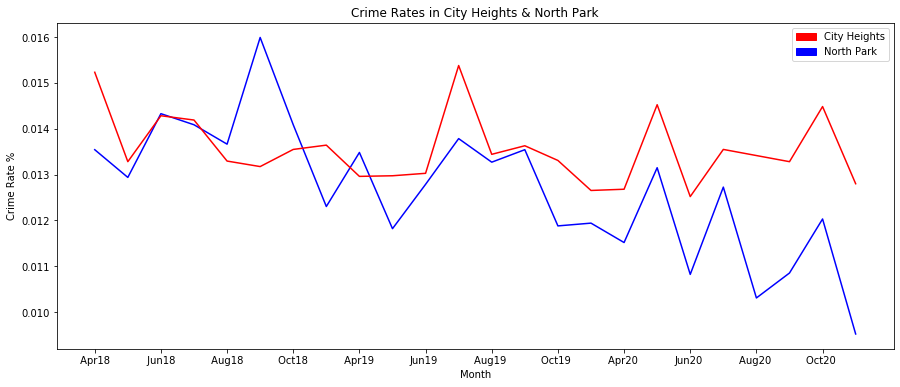

In [21]:
plt.figure(figsize=(15,6))
plt.plot(month_list, prop_NP_list,color='blue')
plt.plot(month_list,prop_CH_list,color='red')

plt.xlabel("Month")
plt.ylabel("Crime Rate %")
plt.title("Crime Rates in City Heights & North Park")

red_patch = mpatches.Patch(color='red', label='City Heights')
blue_patch = mpatches.Patch(color='blue', label='North Park')
plt.legend(handles=[red_patch,blue_patch])
plt.xticks(x_tick)

From the graph we see that City Heights crime rate doesnt seem to go down over the years despite the curfew. On the other hand, we do notice a sizeable decrease overtime in North Park, however we can't draw any conclusions yet. Let's now see how the two neighborhoods compare to the other neighborhoods we selected.

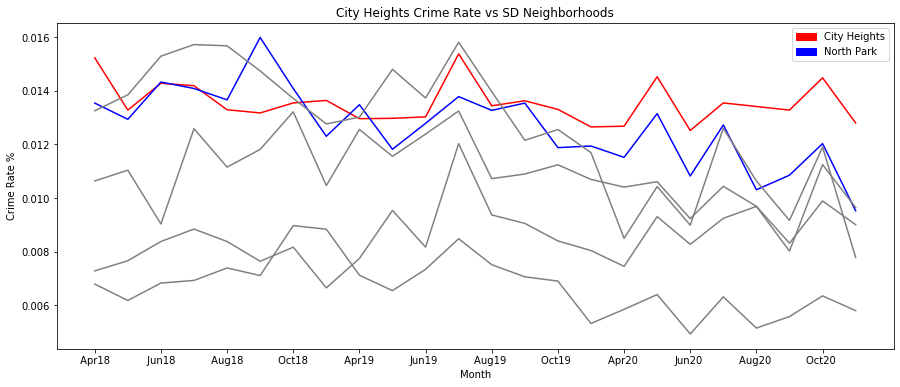

In [22]:
plt.figure(figsize=(15,6))
plt.plot(month_list, prop_CH_list,color='red')

plt.plot(month_list,prop_NP_list,color='blue')
plt.plot(month_list,prop_PB_list,color='gray')
plt.plot(month_list,prop_HC_list,color='gray')
plt.plot(month_list,prop_EN_list,color='gray')
plt.plot(month_list,prop_CM_list,color='gray')
plt.xlabel("Month")
plt.ylabel("Crime Rate %")
plt.title("City Heights Crime Rate vs SD Neighborhoods")
plt.xticks(x_tick)
red_patch = mpatches.Patch(color='red', label='City Heights')
blue_patch = mpatches.Patch(color='blue', label='North Park')
plt.legend(handles=[red_patch,blue_patch])

Across the board, we get a mixed bag of results for each different neighborhood. City Heights and North Park still show as neighborhoods with the highest crime rate when compared to the other neighborhoods. 

In addition to this, as seen in the prior graph there doesnt seem to be any difference in trends between either North Park or City Heights in relation to the other neighborhoods. Its starting to appear that the park curfew is not very impactful. It could be that a majority of crimes occur outside of parks which would be unaffected by the curfew. 

Let's check it out and see just how many crimes near parks make up those that are reported to the police.

In [23]:
df_CHNP_bypark = df_bypark[(df_bypark['Neighborhood'] == "City Heights") | (df_bypark['Neighborhood'] == "North Park")]

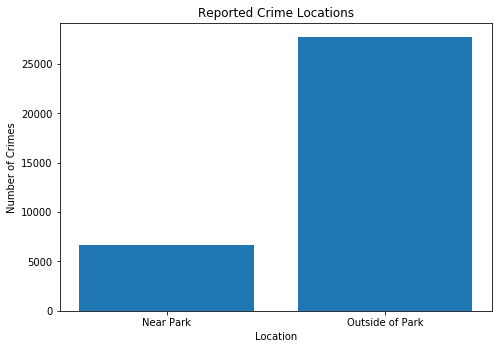

In [24]:
No,Yes = df_CHNP_bypark['By Park'].value_counts()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Near Park', 'Outside of Park']
y = [Yes,No]
ax.bar(x,y)
plt.title("Reported Crime Locations")
plt.ylabel('Number of Crimes')
plt.xlabel("Location")
plt.show()

From our plot, we can see that the crimes near the parks make up a small percentage of the total reported crimes. From the data, we see that around every 1 in 5 crimes are reported by these parks. Let's instead observe the surrounding of the parks themselves to get a closer look. We graph the number of crimes occurred on streets bordering the affected parks for each year. 

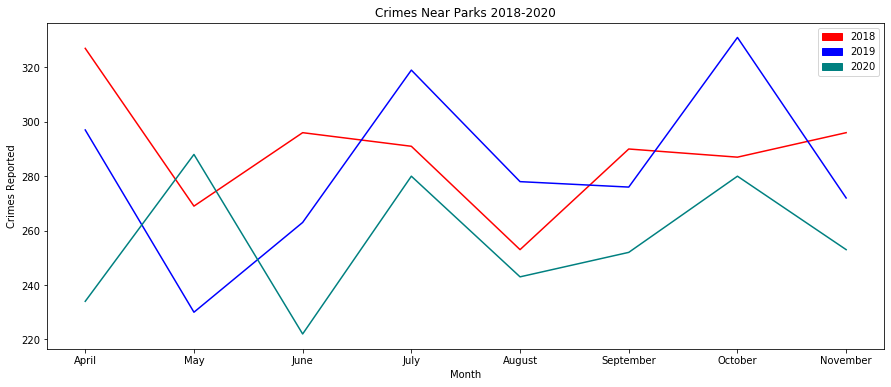

In [25]:
plt.figure(figsize=(15,6))
plt.plot(month_list_yr, park_18,color = "red")
plt.plot(month_list_yr, park_19,color = 'blue')
plt.plot(month_list_yr, park_20,color = 'teal')
plt.xlabel("Month")
plt.ylabel("Crimes Reported")
plt.title("Crimes Near Parks 2018-2020")

eight_patch = mpatches.Patch(color='red', label='2018')
ninth_patch = mpatches.Patch(color='blue', label='2019')
twny_patch = mpatches.Patch(color='teal', label='2020')
plt.legend(handles=[eight_patch,ninth_patch,twny_patch])

Note from this graph that while crimes after the initial months of the curfew went down, they began to rise again near levels of crime before the curfew was instated. This leads us to question now whether or not the curfew is making a statistically significant impact on crime rates. Something to keep into consideration here, is that crime rates have high variance since there can be many factors at play based on location, month, and even temperature. So from this graph, the main take away should be the general over time trend.

In addition, the crimes reported near parks in 2020 are quite lower than the previous years. I believe this may be due in part by the effects of COVID-19, which I will discuss in more detail in the next section.

# Data Analysis & Results

We now will test to see the association between the regions with curfews and the rate of crime across neighborhoods of San Diego. In order to do so, we will use a Chi Squared Test and determine if a difference is significant with a value of 0.05. We will start broad and narrow down our analysis to see if we can obtain more accurate results.

In [26]:
def chi_test(freq_1,freq_2):
        stat, p_value = chisquare([freq_1,freq_2])
        if p_value > 0.05:
            print('No difference found in the number of crimes committed',
                  'Unable to reject null hypothesis based on the p-value:',p_value)
        else:
            print('Difference found in the number of crimes committed',
                'Reject the null hypothesis based on the p-value:', p_value)

First we test the San Diego region overall in terms of crime for 2018 and 2019. Then we check 2019 and 2020.  

In [32]:
sd_month_crimes_18 = df_18['Month'].value_counts()
sd_month_crimes_19 = df_19['Month'].value_counts()
sd_month_crimes_20 = df_20['Month'].value_counts()

for x in range(0,8):
    chi_test(sd_month_crimes_18[x],sd_month_crimes_19[x])

Difference found in the number of crimes committed Reject the null hypothesis based on the p-value: 8.218192527072713e-10
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.1747545036090674
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.8881450009550662
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.4343647124276623
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.1596522189638957
Difference found in the number of crimes committed Reject the null hypothesis based on the p-value: 0.005947129075656422
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.28314499352379086
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.18686

In [34]:
for x in range(0,8):
    chi_test(sd_month_crimes_19[x],sd_month_crimes_20[x])

Difference found in the number of crimes committed Reject the null hypothesis based on the p-value: 2.0059904372825364e-16
Difference found in the number of crimes committed Reject the null hypothesis based on the p-value: 0.0007789217711070586
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.635609524542184
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.8556683199521662
Difference found in the number of crimes committed Reject the null hypothesis based on the p-value: 9.998120819545271e-06
Difference found in the number of crimes committed Reject the null hypothesis based on the p-value: 2.3560094931941046e-10
Difference found in the number of crimes committed Reject the null hypothesis based on the p-value: 4.0059274145843013e-22
Difference found in the number of crimes committed Reject the null hypothesis based on the p-value: 2.6670014494914457e-26


We find from our test that there was a significant difference found in March between 2018 and 2019, which is the month in 2019 that the curfew was put into place. However, each month after showed no substantial difference which shows there is either very little or no association with the curfew and crime. Something else to note is there appears to be a substantial difference between 2019 and 2020. However, it is very likely that COVID-19 is a confounding variable here which may have tipped the crime higher or lower depending on location. From this observation, I will be leaving out 2020's data as the results are not reflective of the previous years of 2018 and 2019.

In order to get a solid answer for our analysis between 2018 and 2019, we pursue further and focus down on specific locations. Next we will look at City Heights and North Park, with their crime rates in each month from March to November in 2018 and 2019. 

In [35]:
#Perform Chi Squared Test on City Heights before the curfew and after the curfew.
for x in range(0,8):
    chi_test(prop_CH_18_list[x],prop_CH_19_list[x])

No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.9892065840166978
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.9984867497090427
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.9939361605392151
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.9944822717711973
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.9992828111151614
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.9977860012917188
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.998829048820805
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-val

In [36]:
#Perform Chi Squared Test on North Park crime rate before curfew and after the curfew
for x in range(0,8):
    chi_test(prop_NP_18_list[x],prop_NP_19_list[x])

No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.9997065649598367
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.9943283834304834
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.9925300386135081
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.9985552754625
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.9980894657304062
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.9886322689404858
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.9890739432669351
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value

From our tests, we can't conclude that there is a significant difference in the crimes between the two years for either neighborhood. From this point we can get an idea of the impact of the curfew, but I'd like to continue and take one step further to see if a more detailed approach will result in different results. I will now test the crimes that took place within the surrounding streets of each park that was given a curfew in 2019. This will give us a more accurate depiction of the impact of the curfew, as it is only concerning the areas nearby the parks themselves.

In [37]:
for x in range(0,8):
    chi_test(park_18[x],park_19[x])

No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.22976627046113451
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.08083184479289378
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.1627894051469576
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.25692592242223855
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.277962585344723
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.5562209630111463
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p-value: 0.07673720795196787
No difference found in the number of crimes committed Unable to reject null hypothesis based on the p

From our Chi Squared tests, above we see that for each month from March to November in 2018 and 2019 there are no substantial differences! Since this is the most direct comparison we can make in this case, we can now conclude that there is no association between curfews on parks and the crime rate around them. Therefore, the curfews that were imposed did not affect crime rates of the parks that were given curfews in 2019. With this result in mind, I reject my hypothesis that crime rates would be reduced by imposing curfews.


# Ethics & Privacy

When cleaning the data set, I left out the primary address and address number to remove any logs that could identify specific locations such as residences. Since road names can extend to a larger area, I did not remove any road or intersecting road information. Additionally, I left in date and time since these elements were vital to our analysis as we compared the effects of park curfews. 

For my analysis, I only used data from one city in Southern California. There can definetely be different results from other areas in the United States especially outside of California, so our results here most certainly cannot be generalized. Furthermore, the parks analyzed were all near the same region in San Diego. This can potentially cause bias in our results since we do not have adequate representation of parks in regions of San Diego with different socio-economic status. It is extremely important that we take note of this, since in lower income areas there can be a larger population of homeless individuals that live near parks and with biased analysis we could end up unintentionally criminalizing homelessness in San Diego.

# Conclusion & Discussion

From my findings, I can conclude that in San Diego, the curfews placed on the parks in North Park and City Heights were not effective in reducing crime. Thus showing that my hypothesis that the curfews would make a difference incorrect.

Some limitations I had was that the parks I analyzed that were given a curfew do not make up a majority of the parks in San Diego. Due to this, our small sample size from our data is a limiting factor that can create bias. When I realized how small the sample size was, I opted to examine the park locations directly for more accurate representation.I believe that if there were more parks that were given curfews and we had longer timeline, we would have recieved more accurate results. Additionally, the curfews placed on the parks were not all the same. City Heights Mini Park was given a different curfew time than the other parks which can also skew the data, since the curfews that start later may not be as effective.

We also saw the effects of COVID-19 on the crimes near parks, with a drastic decrease in crime rate for a majority of the months from April through November. I believe this likely in part caused by the lockdowns earlier this year and the effects of the pandemic on the public, causing many to avoid public areas such as parks. This is in addition to the fact that earlier this year there was a mandatory shutdown for parks and recreation due to COVID-19. This led us to only include data from 2018 and 2019, as the data from 2020 in my opinion are not accurate representations given the extreme circumstances of a pandemic. 

Lastly, its important to keep in mind that this analysis on parks and crimes needs to be conducted carefully and conveyed correctly since it can negatively impact the reputation of specific areas and parks within San Diego. This could result in abandonment of certain parks when there was no real threat from the park to begin with. As well as on the other side, if we convey a message that crimes dont happen near parks it could result in individuals feeling more comfortable in going out to them at night and potentially place themself in the wrong place at the wrong time.
